# TASK 1: Image reading and displaying


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pywt
from skimage.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from skimage.metrics import structural_similarity as ssim

### Task 1.1 Image Read Function for PGM images

In [2]:
def pgm_image_read(path):  # Path of the file
    """
   
    This function is used to read .pgm images instead of an imread() function

    - .pgm images follow a certain format where the first few lines form the header of the file.
    - The header contains values such as the magic number (P2 or P5), comments, file dimensions (width, height, and max value of pixel)
    - Followed by the header is the actual pixel data which is stored in bytes (for P5) or as whitespace-separated ASCII integers (for P2)
    - This function is also able to handle noisy .pgm images

    This function transforms the pixel data into a numpy array.

    The array can be later fed to the imshow() function which will produce the image.

    The only input needed for this function is the **path** to the file
    
    """

    with open(path, mode='rb') as file:  # Opening the file in binary mode
        image = file.read()              # Read the entire file
        lines = image.split(b'\n')       # Split the file content by lines
    
    # Initializing variables
    width = height = max_pixel_value = 0
    pixel_start = 0
    is_ascii = False  # Default to binary (P5)
    i = 1  # Starting from the second line (after the magic number)
    
    magic_number = lines[0].strip()  # The first line contains the magic number (P2 or P5)
    
    
    if len(magic_number) == 2:  

        if magic_number == b'P2':                 # ASCII format (P2)
            is_ascii = True
        elif magic_number == b'P5':               # Binary format (P5)
            is_ascii = False


        # Process the header after the magic number
        for x in lines[1:]:
            if b'#' in x[:1]:                              # Skipping comments (lines starting with '#')
                i += 1
                continue
            
            header_line = x.strip().split()

            if len(header_line) == 2:                      # Width and Height
                width, height = map(int, header_line)
            elif len(header_line) == 1:                    # Max pixel value
                max_pixel_value = int(header_line[0])
                pixel_start = i + 1                        # Pixel data starts after this line
                break  # End of header processing
            i += 1

    else:  # For the case when magic number and dimensions are on the first line (Noisy images)
        
        # Getting dimensions
        first_line = lines[0].strip().split()
        
        magic_number = first_line[0]
        width = int(first_line[1])
        height = int(first_line[2])
        max_pixel_value = int(first_line[3])

        if magic_number == b'P2':  # ASCII format (P2)
            is_ascii = True
        elif magic_number == b'P5':  # Binary format (P5)
            is_ascii = False

        # Skip header lines, which are already parsed
        
        i = 1                                              # Start checking lines after the first one (magic number)
        for x in lines[1:]:
            if b'#' in x[:1]:                              # Skipping comments (lines starting with '#')
                i += 1
                continue

            header_line = x.strip().split()
            
            # The header has already been processed (width, height, max value are defined)
            if len(header_line) == 1 and max_pixel_value == 0:
                max_pixel_value = int(header_line[0])
                pixel_start = i + 1
                break  # End of header processing
            i += 1

    # Processing the pixel data
    if is_ascii:
        pixel_data = b' '.join(lines[pixel_start:]).strip()  # Joining all remaining lines for P2 format
        pixel_list = list(map(int, pixel_data.split()))      # Converting values to integers
        
        
    else:  # For P5 (binary format)
        pixel_data_start = sum(len(line) + 1 for line in lines[:pixel_start])  # Including newline characters
        pixel_data = image[pixel_data_start:]  # Extracting pixel data starting from this position

        # Ensure pixel data matches expected size
        expected_pixel_count = width * height
        pixel_data = pixel_data[:expected_pixel_count]  # Truncate extra bytes if necessary
        pixel_list = list(pixel_data)

    # Create the final numpy array
    pixel_array = np.array(pixel_list).reshape((height, width))
    pixel_array = pixel_array.astype(np.uint8)  # Ensure 8-bit format

    return pixel_array


### Task 1.2 Display PGM Images using function

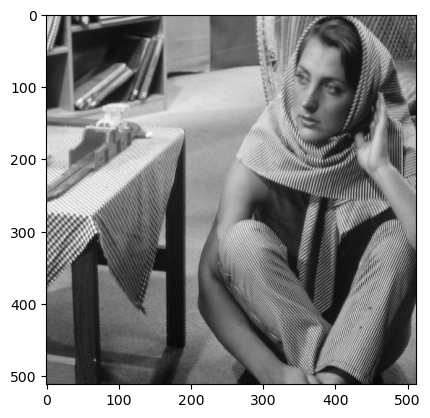

In [3]:
# Image using new function
pixel_array = pgm_image_read(r'Dataset\original\barbara.pgm' )
pgm_image = plt.imshow(pixel_array,cmap = 'gray')
plt.show() 

# TASK 2: Wavelet decomposition

## Task 2.1 FDWT using Haar Transform

In [4]:
import numpy as np

def haar_transform_FDWT(image, decomp_level):
    
    
    def haar_transform_1d(numpy_array):

        n = len(numpy_array)
        output = np.zeros_like(numpy_array)                                   # Creates an output array with 0's equal to the number in the input array
        for i in range(0, n, 2):
            output[i // 2] = (numpy_array[i] + numpy_array[i + 1]) / 2               # Approximation (Averaging) - starts from 0 of array
            output[n // 2 + i // 2] = (numpy_array[i] - numpy_array[i + 1]) / 2      # Detail (Differencing) - starts from the middle of the array
        return output
    
    rows, cols = image.shape                                                 # Getting the shape of the image
    high_freq_coeff = []                   
    current_image = image.copy()

    for level in range(decomp_level):
        
        # Calculating values for rows
        temp = np.zeros_like(current_image)                                  # Creating array of 0's for rows
        for i in range(rows):
            temp[i, :] = haar_transform_1d(current_image[i, :])              # performing 1D transform through rows 

        # Calculating values for columns
        current_image = np.zeros_like(temp)                                  # Creating array of 0's for columns
        
        for i in range(cols):
            current_image[:, i] = haar_transform_1d(temp[:, i])               # performing 1D transform through columns 

        # Getting the different components of decomposition
        half_rows, half_cols = rows // 2, cols // 2                           # Splitting the 2d array into 4 quarters
        LL = current_image[:half_rows, :half_cols]
        LH = current_image[:half_rows, half_cols:]
        HL = current_image[half_rows:, :half_cols]
        HH = current_image[half_rows:, half_cols:]

        high_freq_coeff.append((LH, HL, HH))                    # High Frequency components (details)
        current_image = LL                                      # Low Frequency component (approximation)

        rows, cols = half_rows, half_cols

    return current_image, high_freq_coeff


## Task 2.2 IDWT using Haar wavelet transform

In [5]:
def haar_transform_IDWT(approximation, details, decomp_level):
    
    def inverse_haar_transform_1d(numpy_array):
        
        n = len(numpy_array) // 2                                # No. of pairs
        output = np.zeros_like(numpy_array)                      # Creates an array with 0's equal to the number 
        for i in range(n):
            output[2 * i] = numpy_array[i] + numpy_array[n + i]         # Reconstructed value 1
            output[2 * i + 1] = numpy_array[i] - numpy_array[n + i]     # Reconstructed value 2
        return output

    rows, cols = approximation.shape
    current_image = approximation

    for level in range(decomp_level-1,-1,-1):      # Highest index of decomp_level, stopping right before 0, decrement by 1
        LH, HL, HH = details[level]

        # Combine approximation and details
        half_rows, half_cols = rows, cols          # Taking the frequency components
        temp = np.zeros((2 * half_rows, 2 * half_cols))
        temp[:half_rows, :half_cols] = current_image
        temp[:half_rows, half_cols:] = LH
        temp[half_rows:, :half_cols] = HL
        temp[half_rows:, half_cols:] = HH

        # Process columns             
        current_image = np.zeros_like(temp)        # Creating array of 0's for column
        for i in range(temp.shape[1]):
            current_image[:, i] = inverse_haar_transform_1d(temp[:, i])    # 1D IDWT on columns

        # Process rows
        temp = np.zeros_like(current_image)         # Creating array of 0's for rows
        for i in range(current_image.shape[0]):
            temp[i, :] = inverse_haar_transform_1d(current_image[i, :])    # 1D IDWT on rows

        current_image = temp
        rows, cols = 2 * rows, 2 * cols

    return current_image


### Execution of FDWT and IDWT  

In [6]:
def visualize_frequency_components(approximation, details, decomp_level, max_pixel_value):
    
    plt.figure(figsize=(12, 8))
    plt.title('Wavelet Decomposition Elements')
    for level, (LH, HL, HH) in enumerate(details, start=1):
        # Normalizing components for display
        norm_LL = np.clip(approximation * max_pixel_value, 0, max_pixel_value).astype(np.uint8)
        norm_LH = np.clip(LH * max_pixel_value, 0, max_pixel_value).astype(np.uint8)
        norm_HL = np.clip(HL * max_pixel_value, 0, max_pixel_value).astype(np.uint8)
        norm_HH = np.clip(HH * max_pixel_value, 0, max_pixel_value).astype(np.uint8)

        # Plotting the components
        plt.subplot(decomp_level, 4, (level - 1) * 4 + 1)
        plt.title(f"Level {level} - LL")
        plt.imshow(norm_LL, cmap="gray")
        plt.axis("off")

        plt.subplot(decomp_level, 4, (level - 1) * 4 + 2)
        plt.title(f"Level {level} - LH - Horizontal")
        plt.imshow(norm_LH, cmap="gray")
        plt.axis("off")

        plt.subplot(decomp_level, 4, (level - 1) * 4 + 3)
        plt.title(f"Level {level} - HL - Vertical")
        plt.imshow(norm_HL, cmap="gray")
        plt.axis("off")

        plt.subplot(decomp_level, 4, (level - 1) * 4 + 4)
        plt.title(f"Level {level} - HH - Diagonal")
        plt.imshow(norm_HH, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


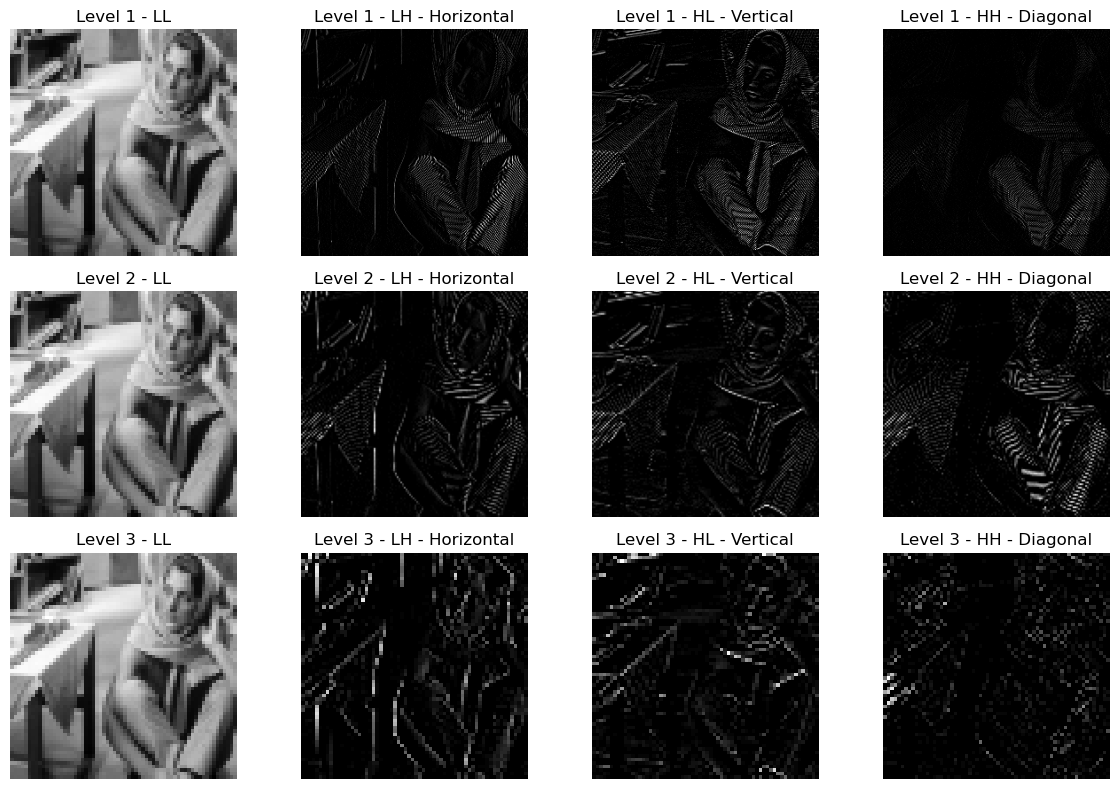

In [7]:
# File path
image_path = r'barbara.pgm'  
image = pgm_image_read(image_path)


#Normalizing image array for best results
max_pixel_value = np.max(image)
image = image/max_pixel_value        

# Level of Decomposition
decomp_level = 3

# Forward DWT
approximation, details = haar_transform_FDWT(image, decomp_level)
# Inverse DWT
reconstructed_image = haar_transform_IDWT(approximation, details, decomp_level)

# Result of FDWT
visualize_frequency_components(approximation, details, decomp_level, max_pixel_value)


### MSE score comparison between Original and Reconstructed Image

Mean Square Error (MSE): 8.613523752410593e-33


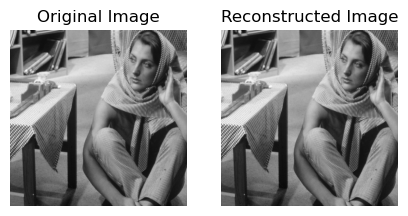

In [8]:
mse = mean_squared_error(image, reconstructed_image)
print(f"Mean Square Error (MSE): {mse}")

# Original image
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')


# Scaling reconstructed image back to 0,255 for display
reconstructed_image = np.clip(reconstructed_image * max_pixel_value, 0, max_pixel_value).astype(np.uint8)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')


plt.show()

# TASK 3: Image denoising  


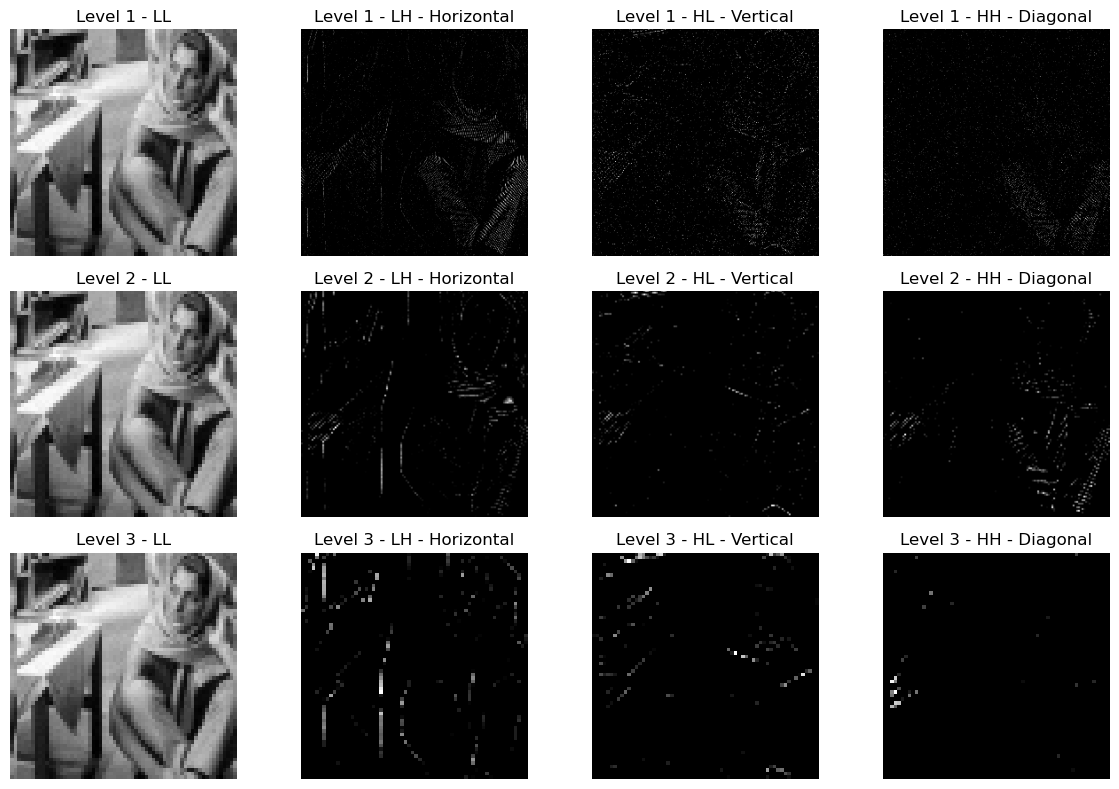

In [9]:
# File path
original_path = r'Dataset\original\barbara.pgm'
noisy_path = r'Dataset\noisy_1\barbara.pgm'

# Read images
noisy_image = pgm_image_read(noisy_path)
original_image = pgm_image_read(original_path)

# Normalize image arrays for best results
max_pixel_value_original = np.max(original_image)
original_image = original_image / max_pixel_value_original 

max_pixel_value_noisy = np.max(noisy_image)
noisy_image = noisy_image / max_pixel_value_noisy

# Level of Decomposition
decomp_level = 3

# Perform Forward DWT on the noisy image
approximation, details = haar_transform_FDWT(noisy_image, decomp_level)



def thresholding(coefficients, threshold, mode='soft'):

    if mode == 'hard':
        #Hard Thresholding keeps coefficients greater than threshold and sets the others to zero. 
        return np.sign(coefficients) * (np.abs(coefficients) > threshold) * coefficients
    elif mode == 'soft':
        #Soft Thresholding shrinks the coefficients towards zero by threshold.
        return np.sign(coefficients) * np.maximum(np.abs(coefficients) - threshold, 0)


# Applying thresholding to the details coefficients
threshold = 0.05
thresholded_details = []
for coeff in details:
    thresholded_level = tuple(thresholding(c, threshold, mode='soft') for c in coeff)
    thresholded_details.append(thresholded_level)

# Perform Inverse DWT with thresholded details
reconstructed_image = haar_transform_IDWT(approximation, thresholded_details, decomp_level)

# Visualize the frequency components (optional, you can skip this if not needed)
visualize_frequency_components(approximation, thresholded_details, decomp_level, max_pixel_value_noisy)


### Task 3.3 Comparing Original and denoised image

Mean Square Error (MSE): 0.038732044618353986
Structural Similarity Index (SSIM): 0.3950585945869456


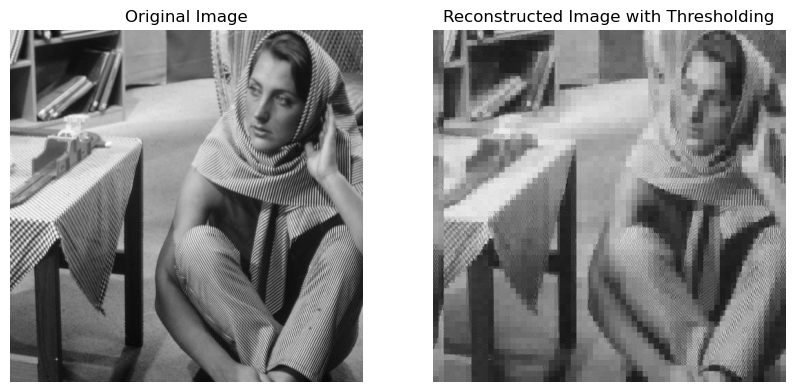

In [10]:
# Compute Mean Square Error (MSE) between the original and reconstructed images
mse = mean_squared_error(original_image, reconstructed_image)
print(f"Mean Square Error (MSE): {mse}")

ssim_value = ssim(original_image, reconstructed_image)
print(f"Structural Similarity Index (SSIM): {ssim_value}")


# Original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Scaling the reconstructed image back to the original pixel value range
reconstructed_image = np.clip(reconstructed_image * max_pixel_value_noisy, 0, max_pixel_value_noisy).astype(np.uint8)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Image with Thresholding")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()